## Testing the application of defocus

To make focus-diverse phase retrieval happen, there are two options for propagation.
- 1) Free-space propagation of focal field via angular spectrum or Fresnel diffraction
- 2) Applying defocus to the starting phase solution

The former option is what was being done for the original phase retrieval routines in image_sharpening.py for Keck. However, the latter can make use of the gradient backpropagation rule for addition that allows for minimal additional code complexity. When constructing the phase $W$, in the forward model, we add some defocus polynomial $W_{020}$,

$$W = \frac{2\pi}{\lambda} \circ \sum_{n} a_{n} Z_{n} + \frac{2\pi}{\lambda} \circ W_{020} = a + b$$

The gradient backpropagation rule for addition is the following:

$$\bar{a} = \bar{W}$$
$$\bar{b} = \bar{W}$$

So because the addition of the focus polynomial is constant, we can ignore it in the reverse model. However, in testing it would appear that I am applying an incorrect amount of defocus. Here we experiment with focus polynomials to determine which produces the right effect.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# The prysm stuff
from prysm.coordinates import make_xy_grid, cart_to_polar
from prysm.propagation import Wavefront, focus_fixed_sampling
from prysm.geometry import circle, spider
from prysm.segmented import CompositeHexagonalAperture
from prysm import thinlens
from prysm.polynomials import (
    noll_to_nm,
    zernike_nm,
    zernike_nm_sequence,
    hopkins,
    sum_of_2d_modes
)

np.random.seed(20240820)

In [2]:
# USER INPUT HERE
# IC = Instrument Configuration
IC = {
    'image_dx' : 4.87, # um
    'pupil_diameter' : 10950, # mm
    'focal_length' : 338492, # mm
    'wavelength' : 0.94, # um
}

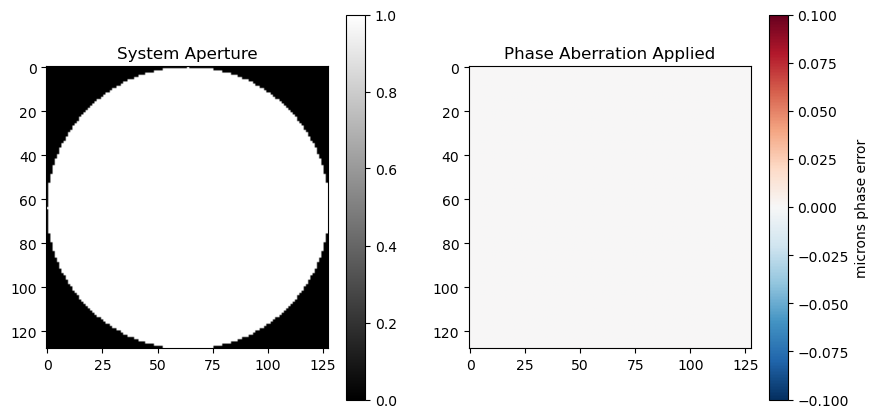

In [18]:
# optical system parameters
epd = IC['pupil_diameter'] # mm
efl = IC['focal_length'] # mm, Keck is F/13 I think
fno = efl / epd
wvl = IC['wavelength'] # um

# build the coordinate grids
x, y = make_xy_grid(128, diameter=epd)
r, t = cart_to_polar(x, y)
dx_p = x[0,1] - x[0,0]

A = circle(epd / 2, r)

# construct a polynomial basis to generate wavefront error
r_z = r / (epd / 2) # normalized radius
nms = [noll_to_nm(j) for j in range(2, 37)]
coefs = np.random.random(len(nms))
basis = list(zernike_nm_sequence(nms, r, t, norm=True))
basis_norm = [b / np.max(np.abs(b)) for b in basis]
phs = sum_of_2d_modes(basis_norm, coefs) * 0
amp = A

plt.figure(figsize=[10,5])
plt.subplot(121)
plt.title('System Aperture')
plt.imshow(A, cmap='gray')
plt.colorbar()
plt.subplot(122)
plt.title('Phase Aberration Applied')
plt.imshow(phs * amp, cmap='RdBu_r')
plt.colorbar(label='microns phase error')
plt.show()

# Propagate to focus
# NOTE: Phase should be in nm, wvl should be in microns, dx_p should be in mm
# NOTE: WAVEFRONT AND FOCUS_FIXED_SAMPLING HAVE DIFFERENT NORMALIZATIONS AND THROW OFF THE ALGORITHM
k = 2 * np.pi / wvl # enforces phs in microns
wf = amp * np.exp(1j * k * phs)


# configure the defocus polynomial
focus_polynomial = hopkins(0, 2, 0, r_z, t, 0)

def prop_to_focus(wavefunction, defocus_waves=0):
    defocus_aberration = amp * np.exp(-1j * 2 * np.pi * focus_polynomial * defocus_waves)


    psf = focus_fixed_sampling(wavefunction=wavefunction * defocus_aberration,
                            input_dx=dx_p,
                            prop_dist=efl,
                            wavelength=wvl,
                            output_dx=IC['image_dx'],
                            output_samples=128)
    psf0 = np.abs(psf)**2
    return psf0

psf0 = prop_to_focus(wf, defocus_waves=0)
psf1 = prop_to_focus(wf, defocus_waves=1)
psf2 = prop_to_focus(wf, defocus_waves=2)
psf3 = prop_to_focus(wf, defocus_waves=3)

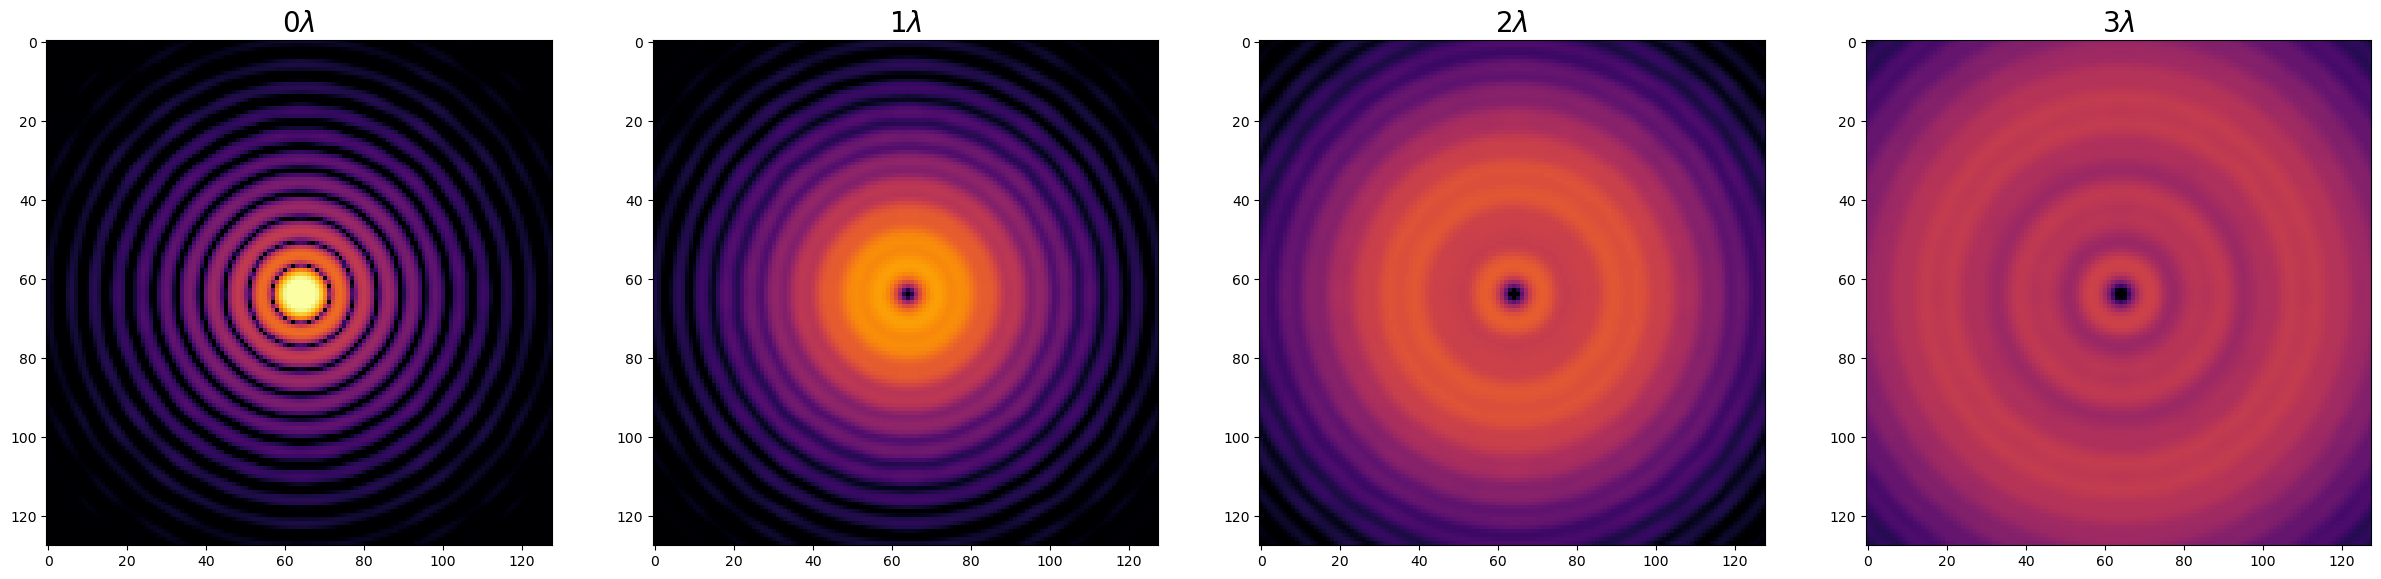

In [19]:
psflist = [psf0, psf1, psf2, psf3]
titles = [f'{i}'+r'$\lambda$' for i in range(0,4)]
fig,axs = plt.subplots(ncols=len(psflist),figsize=[30,10])
for _psf,ax,title in zip(psflist,axs,titles):
    ax.set_title(title,fontsize=20)
    # _psf /= np.max(_psf)
    ax.imshow(np.log10((_psf)),cmap='inferno',vmax=2,vmin=-2)
plt.show()

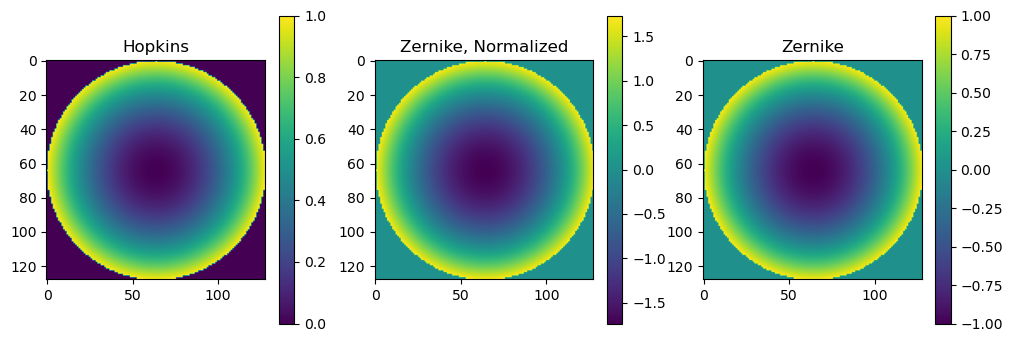

In [23]:
# comparing
hdefocus = hopkins(0, 2, 0, r_z, t, 0)
hzernike_norm = zernike_nm(2, 0, r_z, t, norm=True)
hzernike = zernike_nm(2, 0, r_z, t, norm=False)

plt.figure(figsize=[12,4])
plt.subplot(131)
plt.title('Hopkins')
plt.imshow(hdefocus * A)
plt.colorbar()
plt.subplot(132)
plt.title('Zernike, Normalized')
plt.imshow(hzernike_norm * A)
plt.colorbar()
plt.subplot(133)
plt.title('Zernike')
plt.imshow(hzernike * A)
plt.colorbar()
plt.show()
